---
Download the dataset and import needed functions for part 1

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("grouplens/movielens-20m-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/pavka/.cache/kagglehub/datasets/grouplens/movielens-20m-dataset/versions/1


In [1]:
import numpy
import pandas as pd
import random
from sympy import isprime
import matplotlib.pyplot as plt
from collections import defaultdict
from itertools import combinations
import os
from collections import Counter

---

## <strong> 1. Recommendation System with LSH

## <strong> 1.1 Data Preparation
Download the MovieLens dataset from here. After downloading, explore the dataset to understand the structure and identify any preprocessing steps needed.

<strong> There are in total 6 datasets, let's have a quick look at them

In [5]:
genome_scores = pd.read_csv("dataset/genome_scores.csv", index_col =0)
genome_scores.head(3)

,tagId,relevance
movieId,,
1,1,0.02500
1,2,0.02500
1,3,0.05775


In [6]:
genome_tags = pd.read_csv("dataset/genome_tags.csv", index_col = 0)
genome_tags.head(3)

,tag
tagId,
1,007
2,007 (series)
3,18th century


In [7]:
link = pd.read_csv("dataset/link.csv", index_col = 0)
link.head(3)

,imdbId,tmdbId
movieId,,
1,114709,862.0
2,113497,8844.0
3,113228,15602.0


In [129]:
movie = pd.read_csv("dataset/movie.csv", index_col = 0)
movie.head(3)

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance


In [41]:
rating = pd.read_csv("dataset/rating.csv")
rating.head(3)

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39


In [12]:
tag = pd.read_csv("dataset/tag.csv", index_col = 0)
tag.head(3)

,movieId,tag,timestamp
userId,,,
18,4141,Mark Waters,2009-04-24 18:19:40
65,208,dark hero,2013-05-10 01:41:18
65,353,dark hero,2013-05-10 01:41:19


In [ ]:
# Map movie names into ratings_df
rating= rating.merge(movie, on='movieId')

# Create user_movies dictionary
user_movies = rating.groupby('userId')['movieId'].apply(list).to_dict()

# Create user_ratings dictionary
user_ratings = rating.groupby('userId').apply(
    lambda group: dict(zip(group['movieId'], group['rating']))
).to_dict()


## <strong>1.2 Minhash Signatures</strong>

Using the userId and movieId columns, implement your own MinHash function. This function will hash each user's watched movie list, creating a representation that allows for quick comparisons of user similarities.

    -Important: Implement your MinHash function from scratch—do not use any pre-built hash functions.
    -Use your MinHash function to generate signature vectors for each user based on their rated movies.
    -Experiment with different hash functions and threshold values to find the most effective configurations. Report these results.


Let's first group all the users and their correspective movies.

In [43]:
user_movies = rating.groupby('userId')['movieId'].apply(list).to_dict()

Let's define a simple modulo hash function: <br> <br>
$
h(x) = (a \cdot x + b) \mod p
$

Where:  
- $ x $: Input value  
- $ a $: Coefficient (non-zero)  
- $ b $: Coefficient  
- $ p $: Prime modulus

In [44]:
def hash_function(x, a ,b ,p): 
    return (a*x + b) % p

We generate multiple hash functions.

In [45]:
def create_hash_functions(max_value, max_prime):
    
    primes = [i for i in range(10,max_prime) if isprime(i)]

    # Generate multiple hash functions
    hash_functions = []
    for _ in range(10):
        a = random.randint(1, max_value)  # Random coefficient a (non-zero)
        b = random.randint(0, max_value)  # Random coefficient b
        p = random.choice(primes)  # Predefined prime values
        
        hash_functions.append(lambda x, a=a, b=b, p=p: hash_function(x, a, b, p))
    return hash_functions

Now given these hash functions, we create our signature matrix.

In [28]:
def minhash(user_movies, hash_functions):
    signature_matrix = {}

    for user, movies in user_movies.items():
        signature_vector = []
        for h in hash_functions:
            min_hash = min(h(movie) for movie in movies)  # Compute min hash value for the user's movies
            signature_vector.append(min_hash)
        signature_matrix[user] = signature_vector
    
    return signature_matrix

In [46]:
user_signatures = minhash(user_movies,create_hash_functions(max_value = 10000, max_prime = 1000000))

### **Effectiveness of the Hashing Function**

To evaluate the effectiveness of our MinHash function, we compare the **Jaccard similarity** of two sets with the **MinHash similarity** of their corresponding signature matrices. We then calculate the error using the squared Euclidean distance between the two similarities.

#### 1. **Jaccard Similarity**

The Jaccard similarity between two sets $A $ and $B $ is defined as:

$
J(A, B) = \frac{|A \cap B|}{|A \cup B|}
$

#### 2. **MinHash Similarity**

The MinHash similarity between two signature vectors $\text{sig}_1 $ and $\text{sig}_2 $ is given by:

$
\text{MinHashSim}(\text{sig}_1, \text{sig}_2) = \frac{\text{Number of Matching Hashes}}{\text{Total Number of Hashes}}
$

$
\text{MinHashSim}(\text{sig}_1, \text{sig}_2) = \frac{\sum_{i=1}^n \mathbb{1}(\text{sig}_1[i] = \text{sig}_2[i])}{n}
$

where $\mathbb{1} $ is the indicator function that returns $1 $ if the elements are equal and $0 $ otherwise.

#### 3. **Error Calculation**

The error is computed as the squared Euclidean distance between the true Jaccard similarity and the MinHash similarity:

$
\text{Error} = (J(A, B) - \text{MinHashSim}(\text{sig}_1, \text{sig}_2))^2
$

#### 4. **Total Error Across Users**

For all pairs of users \((u_1, u_2)$, the total error is computed as:

$
\text{Total Error} = \frac{\sum_{(u_1, u_2) \in \text{Users}} \text{Error}(u_1, u_2)}{|\text{Users}|^2}
$

Where:
- $\text{Users} $ is the set of all user pairs.
- $\text{Error}(u_1, u_2) $ is the squared Euclidean error for a pair of users.


In [30]:
# For simplicity we only ran 10000 lines including 90 users

# True Jaccard similarity
def jaccard_similarity(set1, set2):
    return len(set1.intersection(set2)) / len(set1.union(set2))

# MinHash similarity
def minhash_similarity(sig1, sig2):
    return sum(1 for a, b in zip(sig1, sig2) if a == b) / len(sig1)

# Evaluate effectiveness
def evaluate_effectiveness(user_movies, signature_matrix):
    users = list(user_movies.keys())

    tot_error = 0
    for user1, user2 in combinations(users, 2):
        set1, set2 = set(user_movies[user1]), set(user_movies[user2])
        sig1, sig2 = signature_matrix[user1], signature_matrix[user2]
        
        # Compute similarities
        true_jaccard = jaccard_similarity(set1, set2)
        approx_minhash = minhash_similarity(sig1, sig2)
        
        # Calculate Error
        error = (true_jaccard - approx_minhash)**2
        tot_error += error
    
    return tot_error / (len(users)**2)


Let's test our results given different types of values for the hashing function.

In [ ]:
results = []
parameters = []
for i in range(10,1000,5):
    parameters.append(i)
    hash_functions = create_hash_functions(i, i*2) 
    signature_matrix = minhash(user_movies,hash_functions)
    result = evaluate_effectiveness(user_movies,signature_matrix)
    results.append(result)

Let's plot the results.

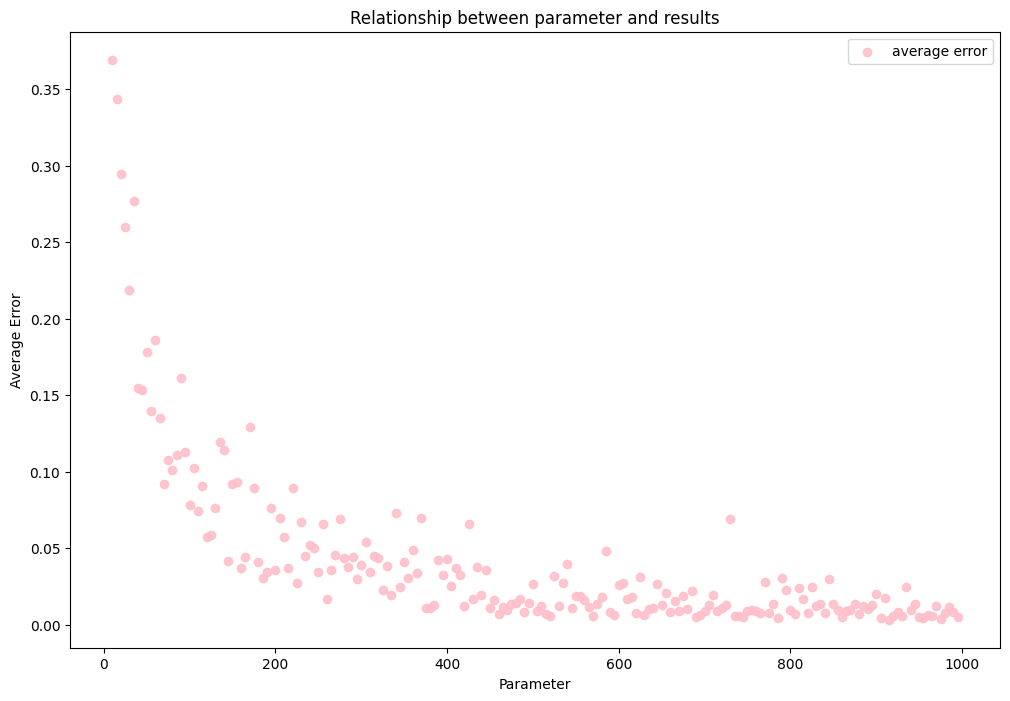

In [32]:
plt.figure(figsize=(12, 8))  
plt.scatter(parameters, results, color='pink', label='average error',alpha = 0.9)  # Plot points
plt.title("Relationship between parameter and results")  
plt.xlabel("Parameter") 
plt.ylabel("Average Error") 
plt.legend() 
plt.show()

We can clearly see a direct relationship between the maximum value in the hashing function and the error. As the maximum value grows, the likelihood of hash collisions decreases, resulting in a better approximation of the true Jaccard similarity and a reduction in error.

## <strong> 1.3 Locality-Sensitive Hashing (LSH) </strong>

### <strong> 1.3.1 Bucket Creation: For each user, divide the MinHash signature into bands and hash each band to form buckets. Users with similar bands should fall into the same buckets.

We create a custom hashing function for buckets

In [47]:
def custom_bucket_hash(sig):
    return sum(sig) % 1001

In [35]:
def lsh(minhash_signatures, num_bands):
    """
    Locality-Sensitive Hashing (LSH) for clustering similar users.

    Args:
        minhash_signatures (dict): Dictionary mapping user IDs to their MinHash signatures.
        num_bands (int): Number of bands to divide the signature into.

    Returns:
        buckets (defaultdict): Mapping from bucket keys to sets of user IDs.
    """
    # Initialize buckets
    buckets = defaultdict(set)
    num_rows = len(next(iter(minhash_signatures.values()))) // num_bands  # Rows per band

    # Create buckets for each band
    for user, signature in minhash_signatures.items():
        for band_idx in range(num_bands):
            # Extract rows for the current band
            start = band_idx * num_rows
            end = start + num_rows
            band = tuple(signature[start:end])  # Ensure immutability for hashing
            # Hash the band and add the user to the corresponding bucket
            bucket_key = custom_bucket_hash(band)
            buckets[bucket_key].add(user)
    
    return buckets



### <strong>  1.3.2 Query: For a given user, identify the two most similar users based on their bucket placement. If a user doesn’t have any similar users in their bucket, adjust the parameters until similar users are found.

In [36]:
def query_similar_users(user, minhash_signatures, buckets):
    """
    Query the most similar users for a given user using LSH buckets.

    Args:
        user (str): User ID for whom to find similar users.
        minhash_signatures (dict): MinHash signatures for all users.
        buckets (defaultdict): Buckets created using LSH.

    Returns:
        List[Tuple[str, float]]: Two most similar users and their MinHash similarity scores.
    """
    user_signature = minhash_signatures[user]
    similar_users = set()

    # Find all buckets containing the given user
    for bucket_users in buckets.values():
        if user in bucket_users:
            similar_users.update(bucket_users)
    
    # Remove the queried user from the set of similar users
    similar_users.discard(user)

    # Compute MinHash similarities
    similarities = [
        (other_user, minhash_similarity(user_signature, minhash_signatures[other_user]))
        for other_user in similar_users
    ]

    # Sort by similarity in descending order and return the top two
    return sorted(similarities, key=lambda x: x[1], reverse=True)[:2]


In [48]:
# Apply LSH
num_bands = 3  # Choose the number of bands
buckets = lsh(user_signatures, num_bands)


# Query similar users for "user1"
similar_users = query_similar_users(1, user_signatures, buckets)
print(f"Similar users for 'user1': {similar_users}")

Similar users for 'user1': [(62235, 0.6), (12453, 0.5)]


### <strong> 1.3.3 Movie Recommendation Logic: </strong>

    If both similar users have rated a movie, recommend this movie based on the average rating.
    If there are no commonly rated movies, recommend the top-rated movies of the most similar user.



In [49]:
def recommend_movies(target_user, user_movies, user_ratings, similar_users, max_recommendations=5):
    """
    Recommends movies for a target user based on similar users' ratings.

    Args:
        target_user (str): The user for whom recommendations are generated.
        user_movies (dict): Movies watched by each user.
        user_ratings (dict): Ratings given by each user for movies.
        similar_users (list): Two most similar users (in descending similarity order).
        max_recommendations (int): Maximum number of recommendations.

    Returns:
        List[Tuple[str, float]]: Recommended movies and their ratings.
    """
    # Movies rated by the target user
    target_user_movies = set(user_movies[target_user])
    
    # Movies rated by similar users
    similar_user_1, similar_user_2 = similar_users
    user1_movies = set(user_movies[similar_user_1])
    user2_movies = set(user_movies[similar_user_2])

    # Find common movies and compute average ratings
    common_movies = user1_movies & user2_movies
    recommendations = []
    for movie in common_movies:
        movie1 = user_ratings[similar_user_1][movie]
        movie2 = user_ratings[similar_user_2][movie]
        avg_rating = (movie1 + movie2) / 2
        recommendations.append((movie, avg_rating))

    # Sort recommendations by average rating
    recommendations.sort(key=lambda x: x[1], reverse=True)

    # Add top-rated movies from the most similar user
    most_similar_user = similar_user_1
    for movie, rating in sorted(user_ratings[most_similar_user].items(), key=lambda x: x[1], reverse=True):
        if len(recommendations) >= max_recommendations:
            break
        if movie not in target_user_movies and movie not in [rec[0] for rec in recommendations]:
            recommendations.append((movie, rating))
    
    # Fill up to 5 recommendations using the second most similar user if needed
    if len(recommendations) < max_recommendations:
        for movie, rating in sorted(user_ratings[similar_user_2].items(), key=lambda x: x[1], reverse=True):
            if len(recommendations) >= max_recommendations:
                break
            if movie not in target_user_movies and movie not in [rec[0] for rec in recommendations]:
                recommendations.append((movie, rating))
    
    return recommendations[:max_recommendations]


In [53]:
target = 1
similar_users = [user for user, score in query_similar_users(target,user_signatures,buckets)]
recommendations = recommend_movies(target_user=1, 
                                   user_movies=user_movies, 
                                   user_ratings=user_ratings, 
                                   similar_users=similar_users)

### <strong> 1.3.4 Final Recommendation: Provide at most five movies to the user.

In [54]:
recommendations_df = pd.DataFrame(recommendations, columns=['movieId', 'score'])
result_df = recommendations_df.merge(movie, on='movieId', how='left')
result_df[['title', 'score']]

,title,score
0,Raiders of the Lost Ark (Indiana Jones and the...,5.0
1,Back to the Future (1985),5.0
2,Wallace & Gromit: The Wrong Trousers (1993),5.0
3,Star Wars: Episode IV - A New Hope (1977),4.5
4,Some Like It Hot (1959),4.5


---

In [4]:
from kmeans import *
dataframes = {}
for dataset in os.listdir(path): # list all files in the directory
    print(dataset)
    dataframes[dataset] = pd.read_csv(os.path.join(path, dataset)) # load the dataset into a pandas dataframe

tag.csv
genome_tags.csv
link.csv
movie.csv
rating.csv
genome_scores.csv


In [135]:
for dataset in dataframes:
    print(dataset)
    print(f"Shape: {dataframes[dataset].shape}")
    print(dataframes[dataset].head(3))
    print()

movie.csv
Shape: (27278, 3)
   movieId                    title  \
0        1         Toy Story (1995)   
1        2           Jumanji (1995)   
2        3  Grumpier Old Men (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  

genome_tags.csv
Shape: (1128, 2)
   tagId           tag
0      1           007
1      2  007 (series)
2      3  18th century

tag.csv
Shape: (465564, 4)
   userId  movieId          tag            timestamp
0      18     4141  Mark Waters  2009-04-24 18:19:40
1      65      208    dark hero  2013-05-10 01:41:18
2      65      353    dark hero  2013-05-10 01:41:19

link.csv
Shape: (27278, 3)
   movieId  imdbId   tmdbId
0        1  114709    862.0
1        2  113497   8844.0
2        3  113228  15602.0

rating.csv
Shape: (20000263, 4)
   userId  movieId  rating            timestamp
0       1        2     3.5  2005

In [5]:
tags_df = dataframes['tag.csv']
movies_df = dataframes['movie.csv']
ratings_df = dataframes['rating.csv']
links_df = dataframes['link.csv']
genome_scores_df = dataframes['genome_scores.csv']
genome_tags_df = dataframes['genome_tags.csv']

print(movies_df.info()); print(f"Are the movie id's unique? {movies_df.movieId.nunique() == movies_df.shape[0]}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB
None
Are the movie id's unique? True


---

## 2. Grouping Movies Together!

In this section, you will explore clustering algorithms to group the movies you have based on specific features you choose to consider for them.

### 2.1 Feature Engineering

As you know, the dataset provided isn't particularly clean or well-structured to represent the features of the movies. Therefore, your first step is to create a more suitable set of attributes (variables, features, covariates) to represent the movies based on the available information. Here are some variables or features you might consider for clustering:

1. **movieid**: id of each movie
2. **genres**: list of genres attached to the movie (given that a movie may have several genres, it's essential to devise a method to accurately represent the genres for each movie)
3. **ratings_avg**: the average ratings provided by users for the movie
4. **relevant_genome_tag**: the most relevant tag to the movie given in the genome set
5. **common_user_tag**: the most common tag given to the movie by the users

In addition to the above features, include at least three additional features for clustering.

Note: If you have accurately identified and applied the methods for representing the features, you should have more than eight features!
How could this happen? Take a moment to think about it.

---

Keeping in mind that we are preparing the dataset for *movies* and that we will be clustering movies later on! I will keep the movie id column as it is and will start by using the movies dataset to make one hot encoding for genres and represent the genres for each movieid.

In [6]:
movies_df.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


Some field in the genres column contain values such as (no genres listed). We can see that the total number of such values are 246:

In [7]:
print(f'Number of Values containing "(no genres listed)" are: {movies_df['genres'].str.contains('no').sum()}')

Number of Values containing "(no genres listed)" are: 246


Now because our movies dataset have over 27000 movies, we can safely drop such rows!

In [8]:
# replace these with None
movies_df['genres'] = movies_df['genres'].apply(lambda x: x if x != '(no genres listed)' else None)

# dropping such rows
movies_df.dropna(subset=['genres'], inplace=True)

In [9]:
# Feature 1: One-hot encode genres
movies_df["genres"] = movies_df["genres"].str.split("|")
genre_list = set(g for genres in movies_df["genres"] for g in genres)
for genre in genre_list:
    movies_df[genre] = movies_df["genres"].apply(lambda x: 1 if genre in x else 0)

In [10]:
movies_df.head(3)
movies_df.shape

(27032, 22)

Now, going to the the second feature, I will use the ratings dataset to calculate average ratings for each movieid and merge it with the original movies dataset

In [11]:
print(ratings_df.shape)
ratings_df.head(3)

(20000263, 4)


,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39


In [12]:
# Feature 2: Average rating
rating_avg = ratings_df.groupby("movieId")["rating"].mean().rename("ratings_avg")
rating_avg.head(3)
rating_avg.shape

(26744,)

The shape of the movies datframe and the rating_avg series are different. It means that there are some movie ids for which no ratings are given. Because our ultimate task is to cluster movies based on some particular features, we will only keep the movie ids for which there are ratings, i.e. by performing an *inner join*. We will adapt the same strategy for other features as well. However, I would like to *emphasize* that this strategy will greatly reduce the size of the movies set!

In [13]:
movies_df = movies_df.merge(rating_avg, on="movieId")
movies_df.head(3)
movies_df.shape

(26502, 23)

In [14]:
tags_df.head(3)

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19


In [15]:
# Feature 3: Common user tags
top_10_common_tags = tags_df.groupby('movieId')['tag'].apply(list).apply(lambda x: Counter(x).most_common(10))
top_10_common_tags.head(3)
top_10_common_tags.shape

(19545,)

In [16]:
movies_df = movies_df.merge(top_10_common_tags, on='movieId')
movies_df.head(3)
movies_df.shape

(18978, 24)

Now, we will normalize the tag counts into relative frequencies

In [17]:
movies_df["tag"] = movies_df["tag"].apply(lambda tags: [(tag, round(count/sum(count for tag, count in tags), 2)) for tag, count in tags])
movies_df.head(3)

,movieId,title,genres,Musical,Romance,Comedy,Thriller,Drama,Adventure,Crime,...,Sci-Fi,Horror,Mystery,Documentary,Action,Fantasy,Children,War,ratings_avg,tag
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,1,0,0,1,0,...,0,0,0,0,0,1,1,0,3.921240,"[(Pixar, 0.26), (animation, 0.18), (Disney, 0...."
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",0,0,0,0,0,1,0,...,0,0,0,0,0,1,1,0,3.211977,"[(Robin Williams, 0.25), (time travel, 0.14), ..."
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,3.151040,"[(moldy, 0.15), (old, 0.15), (sequel, 0.15), (..."


In [18]:
movies_df.rename(columns={'tag': 'top_10_user_defined_tags'}, inplace=True)

Because we will be performing PCA and Clustering eventually, the dataset features needs to be numeric in nature. I could have inserted only the first most common user defined tag for each movie, but I inserted 10 most common for the following reason: Use these tags to come up with a metric that show relevance_score_for_tags for each movie id.

The `relevance_score_for_tags` for a movie is computed as:

$$ \text{Relevance Score} = \sum_{t \in \text{movie tags}} \text{Relevance}_t \cdot \text{GlobalWeight}_t $$

#### Components:

1. **Relevance of the Tag** $ \text{Relevance}_t $:
   - Represents how strongly the tag $ t $ is associated with the movie, based on the `relevance` of a tag deried using its relative frequency which is computed using the frequency each user labelled (tagged) the movie / total tags
   - Tags with higher relevance contribute more to the score.

2. **Global Weight of the Tag** $ \text{GlobalWeight}_t $:
   - Captures how "rare" or "informative" the tag $t$ is across all movies. 
   - Tags that appear in fewer movies have higher weights because they are more distinctive.
   - Modeled using:
     $$
     \text{GlobalWeight}_t = \log \frac{N}{n_t}
     $$
     Where $N$ is the total number of movies, and $n_t$ is the number of movies containing the tag $t$.



### **How to Interpret the Score**
1. **High Relevance Score:**
   - The movie is strongly associated with its top tags.
   - The tags are unique or rare across the dataset, making the movie more distinct.
   - Example: A movie with unique tags like "Mind-Boggling" or "Historical" may have a higher score than one with generic tags like "Drama" or "Comedy."

2. **Low Relevance Score:**
   - The movie is associated with common tags or tags with low relevance.
   - The movie might not have a strong identity defined by its tags.
   - Example: A movie tagged with common terms like "Drama" and "Action" might have a lower score than one tagged with niche terms like "Sci-Fi Thriller."

In [19]:
# Flatten the list of all tags for all movies
all_tags = [tag for tags in movies_df['top_10_user_defined_tags'] for tag, count in tags]

# Count occurrences of each tag
tag_counts = Counter(all_tags)

# Total number of movies
total_movies = len(movies_df)

# Compute the global weight for each tag (inverse tag frequency)
global_weights = {tag: np.log(total_movies / count) for tag, count in tag_counts.items()}

def compute_relevance_score(tags, global_weights):
    score = 0
    for tag, relevance in tags:
        global_weight = global_weights.get(tag, 0)
        score += relevance * global_weight
    return score

# Compute the relevance score for each movie
movies_df['relevance_score_for_tags'] = movies_df['top_10_user_defined_tags'].apply(
    lambda tags: compute_relevance_score(tags, global_weights)
)

In [20]:
movies_df.head(3)

,movieId,title,genres,Musical,Romance,Comedy,Thriller,Drama,Adventure,Crime,...,Horror,Mystery,Documentary,Action,Fantasy,Children,War,ratings_avg,top_10_user_defined_tags,relevance_score_for_tags
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,1,0,0,1,0,...,0,0,0,0,1,1,0,3.921240,"[(Pixar, 0.26), (animation, 0.18), (Disney, 0....",5.600549
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",0,0,0,0,0,1,0,...,0,0,0,0,1,1,0,3.211977,"[(Robin Williams, 0.25), (time travel, 0.14), ...",6.366281
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,3.151040,"[(moldy, 0.15), (old, 0.15), (sequel, 0.15), (...",8.153489


For the fourth feature, we will make use of genome tags and their relavance from the `genome_tags` and `genome_scores` dataset, eventually merging them abck to the original movies dataset

In [21]:
genome_scores_df.head(3)

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775


In [22]:
genome_tags_df.head(3)

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century


The total number of unique genome_scores_df for each movie ids are 10381 - further reducing the size of the dataset!

In [23]:
genome_scores_df.movieId.nunique()

10381

In [24]:
# Sort genome_scores_df by movieId and relevance in descending order
sorted_genome_scores_df = genome_scores_df.sort_values(by=['movieId', 'relevance'], ascending=[True, False])

# Group by movieId and select the top 10 tags for each movie using groupby().apply()

def get_top_tags(group):
    return group.head(10)

top_10_relevant_tags = sorted_genome_scores_df.groupby('movieId').apply(get_top_tags).reset_index(drop=True)

# Merge with genome_tags_df to get the tag names
relevant_tags = top_10_relevant_tags.merge(genome_tags_df, on='tagId')

/tmp/ipykernel_72978/4148761769.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_10_relevant_tags = sorted_genome_scores_df.groupby('movieId').apply(get_top_tags).reset_index(drop=True)


In [25]:
relevant_tags.head(3)

,movieId,tagId,relevance,tag
0,1,1036,0.99925,toys
1,1,244,0.99850,computer animation
2,1,786,0.99600,pixar animation


In [26]:
# Aggregate tags into a list for each movieId
tag_sets = relevant_tags.groupby('movieId').apply(lambda x: list(zip(x['tag'], x['relevance']))).reset_index()
tag_sets.columns = ['movieId', 'tag_relevance']
# Make movieId the index of the dataframe
tag_sets.set_index('movieId', inplace=True)

tag_sets.head(3)

/tmp/ipykernel_72978/1015402690.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tag_sets = relevant_tags.groupby('movieId').apply(lambda x: list(zip(x['tag'], x['relevance']))).reset_index()


,tag_relevance
movieId,
1,"[(toys, 0.99925), (computer animation, 0.9985)..."
2,"[(adventure, 0.981), (jungle, 0.967), (childre..."
3,"[(good sequel, 0.9745), (sequel, 0.9505), (seq..."


In [27]:
# Merge the movie dataset with the tag_sets to add the 10 most relevant genome tags
movies_df = movies_df.merge(tag_sets, on="movieId")
movies_df.rename(columns={"tag_relevance": "10_most_relevant_genome_tags"}, inplace=True)
# Display the updated dataframe
movies_df.head(3)

,movieId,title,genres,Musical,Romance,Comedy,Thriller,Drama,Adventure,Crime,...,Mystery,Documentary,Action,Fantasy,Children,War,ratings_avg,top_10_user_defined_tags,relevance_score_for_tags,10_most_relevant_genome_tags
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,1,0,0,1,0,...,0,0,0,1,1,0,3.921240,"[(Pixar, 0.26), (animation, 0.18), (Disney, 0....",5.600549,"[(toys, 0.99925), (computer animation, 0.9985)..."
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",0,0,0,0,0,1,0,...,0,0,0,1,1,0,3.211977,"[(Robin Williams, 0.25), (time travel, 0.14), ...",6.366281,"[(adventure, 0.981), (jungle, 0.967), (childre..."
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,1,1,0,0,0,0,...,0,0,0,0,0,0,3.151040,"[(moldy, 0.15), (old, 0.15), (sequel, 0.15), (...",8.153489,"[(good sequel, 0.9745), (sequel, 0.9505), (seq..."


The `relevance_score_for_genome_tags` for a movie is computed as:

$$ \text{Relevance Score} = \sum_{t \in \text{movie tags}} \text{Relevance}_t \cdot \text{GlobalWeight}_t $$

#### Components:

1. **Relevance of the Tag** $ \text{Relevance}_t $:
   - Represents how strongly the tag $ t $ is associated with the movie, based on the `relevance` field in the genome dataset. 
   - Tags with higher relevance contribute more to the score.

2. **Global Weight of the Tag** $ \text{GlobalWeight}_t $:
   - Captures how "rare" or "informative" the tag $t$ is across all movies. 
   - Tags that appear in fewer movies have higher weights because they are more distinctive.
   - Modeled using:
     $$
     \text{GlobalWeight}_t = \log \frac{N}{n_t}
     $$
     Where $N$ is the total number of movies, and $n_t$ is the number of movies containing the tag $t$.



### **How to Interpret the Score**
1. **High Relevance Score:**
   - The movie is strongly associated with its top tags.
   - The tags are unique or rare across the dataset, making the movie more distinct.
   - Example: A movie with unique tags like "007" or "Commander" may have a higher score than one with generic tags like "Drama" or "Action."

2. **Low Relevance Score:**
   - The movie is associated with common tags or tags with low relevance.
   - The movie might not have a strong identity defined by its genome tags.
   - Example: A movie tagged with common terms like "Drama" and "Action" might have a lower score than one tagged with niche terms like "Sci-Fi Thriller."

In [28]:
# Flatten the list of all tags for all movies
all_tags = [tag for tags in movies_df['10_most_relevant_genome_tags'] for tag, count in tags]

# Count occurrences of each tag
tag_counts = Counter(all_tags)

# Total number of movies
total_movies = len(movies_df)

# Compute the global weight for each tag (inverse tag frequency)
global_weights = {tag: np.log(total_movies / count) for tag, count in tag_counts.items()}

In [29]:
def compute_relevance_score(tags, global_weights):
    score = 0
    for tag, relevance in tags:
        global_weight = global_weights.get(tag, 0)
        score += relevance * global_weight
    return score

# Compute the relevance score for each movie
movies_df['relevance_score_for_genome_tags'] = movies_df['10_most_relevant_genome_tags'].apply(
    lambda tags: compute_relevance_score(tags, global_weights)
)

In [30]:
movies_df.head(3)

,movieId,title,genres,Musical,Romance,Comedy,Thriller,Drama,Adventure,Crime,...,Documentary,Action,Fantasy,Children,War,ratings_avg,top_10_user_defined_tags,relevance_score_for_tags,10_most_relevant_genome_tags,relevance_score_for_genome_tags
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,1,0,0,1,0,...,0,0,1,1,0,3.921240,"[(Pixar, 0.26), (animation, 0.18), (Disney, 0....",5.600549,"[(toys, 0.99925), (computer animation, 0.9985)...",43.017868
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",0,0,0,0,0,1,0,...,0,0,1,1,0,3.211977,"[(Robin Williams, 0.25), (time travel, 0.14), ...",6.366281,"[(adventure, 0.981), (jungle, 0.967), (childre...",33.314003
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,1,1,0,0,0,0,...,0,0,0,0,0,3.151040,"[(moldy, 0.15), (old, 0.15), (sequel, 0.15), (...",8.153489,"[(good sequel, 0.9745), (sequel, 0.9505), (seq...",26.493936


Now, the task is to make 4 additional features. Namely `rating_counts` depicting the number of ratings given by users for each movie id, `genere_diversity`: depicting number of generes associated to each movie id, and `user_tag_diversity`: depicting range of user-defined tags associated to each movie id.

In [31]:
# Additional features

# 6th Rating count
rating_count = ratings_df.groupby("movieId")["rating"].count().rename("rating_count")
movies_df = movies_df.merge(rating_count, on="movieId")

# 7th Genre diversity
movies_df["genre_diversity"] = movies_df[list(genre_list)].sum(axis=1)

# 8th User-defined Tag diversity
user_tag_diversity = tags_df.groupby("movieId")["tag"].nunique().rename("tag_diversity")
movies_df = movies_df.merge(user_tag_diversity, on="movieId")

movies_df.head(3)

,movieId,title,genres,Musical,Romance,Comedy,Thriller,Drama,Adventure,Crime,...,Children,War,ratings_avg,top_10_user_defined_tags,relevance_score_for_tags,10_most_relevant_genome_tags,relevance_score_for_genome_tags,rating_count,genre_diversity,tag_diversity
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,1,0,0,1,0,...,1,0,3.921240,"[(Pixar, 0.26), (animation, 0.18), (Disney, 0....",5.600549,"[(toys, 0.99925), (computer animation, 0.9985)...",43.017868,49695,5,84
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",0,0,0,0,0,1,0,...,1,0,3.211977,"[(Robin Williams, 0.25), (time travel, 0.14), ...",6.366281,"[(adventure, 0.981), (jungle, 0.967), (childre...",33.314003,22243,3,35
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",0,1,1,0,0,0,0,...,0,0,3.151040,"[(moldy, 0.15), (old, 0.15), (sequel, 0.15), (...",8.153489,"[(good sequel, 0.9745), (sequel, 0.9505), (seq...",26.493936,12735,2,15


In [32]:
print(f"Shape of the dataset: {movies_df.shape}")
print(f"Missing values: {movies_df.isna().sum()}")
movies_df.info()

Shape of the dataset: (9815, 30)
Missing values: movieId                            0
title                              0
genres                             0
Musical                            0
Romance                            0
Comedy                             0
Thriller                           0
Drama                              0
Adventure                          0
Crime                              0
Film-Noir                          0
Western                            0
IMAX                               0
Animation                          0
Sci-Fi                             0
Horror                             0
Mystery                            0
Documentary                        0
Action                             0
Fantasy                            0
Children                           0
War                                0
ratings_avg                        0
top_10_user_defined_tags           0
relevance_score_for_tags           0
10_most_relevant_genome_ta

In [33]:
#let's save the dataset
movies_df.to_csv("movies_data.csv") 
movies_df.shape

(9815, 30)

---

**Question** : If you have accurately identified and applied the methods for representing the features, you should have more than eight features! How could this happen? Take a moment to think about it.

**Answer** : Genre column was made into one hot encoding, making many features!

---

### 2.2 Choose your features (variables)!

With multiple features available for the movies, you need to consider the following two questions: 1. Should you normalize the data or leave it as is? 2. Should you include all these features, or can you reduce the dimensionality of the data?  

1. What is the importance of normalizing the data in your analysis, and how does it impact the effectiveness of the clustering algorithms you plan to use?
2. If you find that normalizing the values is beneficial, please proceed to normalize the data. To simplify this task, refer to the scikit-learn package for tools and functions that facilitate data normalization.
3. Could you provide some insights on dimensionality reduction? What techniques would be effective for reducing the number of features in the dataset, and why might this be beneficial for the analysis?
4. If you believe dimensionality reduction would be advantageous, please select a method to reduce the dimensionality of the data.

---

1. Many learning algorithms assume that all features are normalised to some certain range with a certain standard deviation, for example mean of 0 and standard deviation of 1. For example, Principal Component Analysis (PCA) **requires** the variables to be normalized. This is because PCA is sensitive to the variances of the original variables. If the variables are on different scales, those with larger scales will dominate the principal components, which can lead to misleading results.  
    
    Also, we need normalization for clustering. Normalisation ensures that all features contribute equally to the distance calculations used in clustering algorithms. Without normalization, features with larger scales can dominate the distance metrics, leading to biased clustering results.
    
    Similarly, K-Means rely on distance metrics (e.g., Euclidean distance) to group similar data points. Normalizing the data ensures that these distance metrics are meaningful and not skewed by features with different scales.

2. As outlined above, normalizing the real numbers to a certain is crucial to some learning algorithms. Thus, we will proceed with the `StandardScaler()` function to normalise our data 

In [34]:
movies_df = pd.read_csv('movies_data.csv',index_col=0)
movies_df.drop(columns=["genres", "title", "movieId", "top_10_user_defined_tags", "10_most_relevant_genome_tags"], inplace=True)

# Now, we will normalise the data using StandardScaler from sklearn
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
columns_to_scale = ['ratings_avg','relevance_score_for_tags','relevance_score_for_genome_tags','rating_count','genre_diversity','tag_diversity']

movies_df[columns_to_scale] = scaler.fit_transform(movies_df[columns_to_scale])

movies_df.head(3)

,Musical,Romance,Comedy,Thriller,Drama,Adventure,Crime,Film-Noir,Western,IMAX,...,Action,Fantasy,Children,War,ratings_avg,relevance_score_for_tags,relevance_score_for_genome_tags,rating_count,genre_diversity,tag_diversity
0,0,0,1,0,0,1,0,0,0,0,...,0,1,1,0,1.262229,-0.945572,1.485906,9.851924,2.513739,3.284323
1,0,0,0,0,0,1,0,0,0,0,...,0,1,1,0,-0.151021,-0.265733,-0.161384,4.180585,0.702792,0.885955
2,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,-0.272441,1.321004,-1.319131,2.216317,-0.202682,-0.092971


---

3. Could you provide some insights on dimensionality reduction? What techniques would be effective for reducing the number of features in the dataset, and why might this be beneficial for the analysis?

Dimensionality reduction refers to techniques that reduce the number of features in a dataset in such a way that the reduced dataset can still capture the essential information contained in the original dataset. Some techniques that can be used for dimensionality reduction include:

- **Principal Component Analysis (PCA)**: PCA is a linear dimensionality reduction technique that aims to find the directions (principal components) along which the variance of the data is maximized. By projecting the data onto a lower-dimensional subspace spanned by the principal components, PCA can reduce the dimensionality of the data while retaining most of the variance.
- **Singular Value Decomposition (SVD)**: SVD is a matrix factorization technique that can be used for dimensionality reduction. By decomposing the data matrix into three matrices, SVD can capture the underlying structure of the data and reduce its dimensionality.
- **Linear Discriminant Analysis (LDA)**: LDA is a supervised dimensionality reduction technique that aims to find the directions that maximize the separation between different classes in the data. By projecting the data onto the directions that maximize the class separation, LDA can reduce the dimensionality of the data while preserving the class structure.

Dimensionality reduction can be beneficial for the analysis for several reasons, for example:
- **Reduced computational complexity**: By reducing the number of features in the dataset, dimensionality reduction can lead to faster training and inference times for machine learning models.
- **Noise reduction**: Dimensionality reduction can help remove noisy features from the dataset, which can improve the generalization performance of machine learning models.
- **Visualization**: Dimensionality reduction techniques such as PCA can be used to visualize high-dimensional data in a lower-dimensional space, making it easier to interpret and analyze the data.

4. If you believe dimensionality reduction would be advantageous, please select a method to reduce the dimensionality of the data.

We will use PCA for dimensionality reduction! PCA works by transforming the original features into a set of orthogonal components that capture the variance in the data. The key idea behind PCA is to identify the directions (principal components) in the feature space where the data varies the most. These components are ordered in decreasing order of the variance they explain, with the first principal component explaining the most variance. If the reduction in the number of features is significant, we will incorporate the PCA. Else, we will stick with our original dataset.

NB: Will will only perform PCA on numeric columns that are not one hot encoded, because PCA assumes that the relationships between features are linear. However, one-hot encoding creates features that are not linearly related

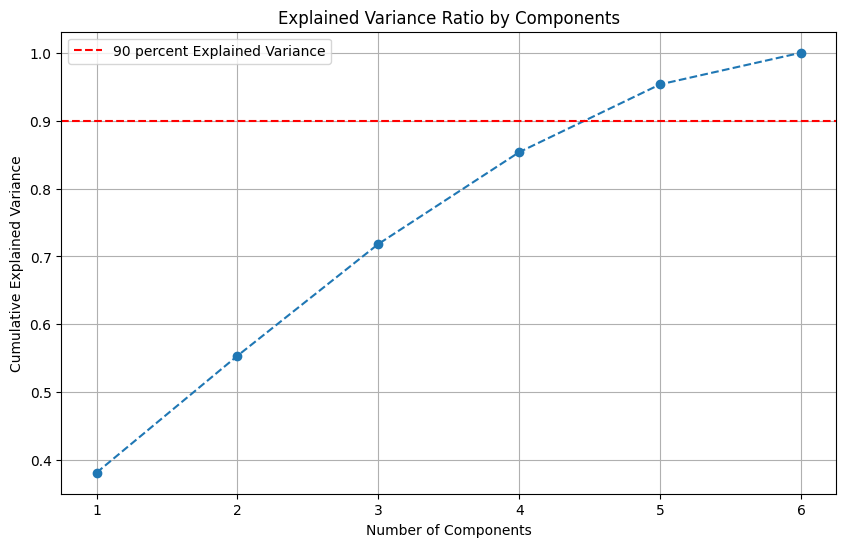

In [35]:
# data for PCA
pca_data = movies_df[columns_to_scale]

# Lets perform the PCA

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=len(pca_data.columns))
pca.fit(pca_data)

# Plotting the explained variance ratio

plt.figure(figsize=(10, 6))

plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title("Explained Variance Ratio by Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.axhline(0.90, color='red', linestyle='--', label='90 percent Explained Variance')
plt.legend()
plt.grid()
plt.show()

Since we need more than 4 components (i.e. 5 components) to capture atleast 90% of the variance in the data, the reduction is not that significant from our original 6 features. However, we will still use the PCA data because of the added benefits of reduced dimensions

In [36]:
# Now, we will make use of 90% explained variance ratio to reduce the number of components

pca = PCA(n_components=0.90)
pca.fit(pca_data)

pca_data = pca.transform(pca_data)
pca_data.shape

(9815, 5)

In [37]:
one_hot_cols = [col for col in movies_df.columns if col not in columns_to_scale]

# merge the pca_data with the original dataset
pca_df = pd.DataFrame(pca_data, columns=[f"PC{i+1}" for i in range(pca_data.shape[1])])
movies_df = pd.concat([movies_df[one_hot_cols], pca_df], axis=1)
movies_df.head(3)

,Musical,Romance,Comedy,Thriller,Drama,Adventure,Crime,Film-Noir,Western,IMAX,...,Documentary,Action,Fantasy,Children,War,PC1,PC2,PC3,PC4,PC5
0,0,0,1,0,0,1,0,0,0,0,...,0,0,1,1,0,8.672747,-2.893161,0.322203,4.369092,-0.435482
1,0,0,0,0,0,1,0,0,0,0,...,0,0,1,1,0,2.669062,-1.511226,0.093075,2.476483,-0.191862
2,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0.154748,-0.066092,0.735749,2.506466,-0.643795


In [38]:
# scale the data for clustering
columns_to_scale = [col for col in movies_df.columns if col.startswith("PC")]
scaler = StandardScaler()
movies_df[columns_to_scale] = scaler.fit_transform(movies_df[columns_to_scale])

movies_df.head(3)


,Musical,Romance,Comedy,Thriller,Drama,Adventure,Crime,Film-Noir,Western,IMAX,...,Documentary,Action,Fantasy,Children,War,PC1,PC2,PC3,PC4,PC5
0,0,0,1,0,0,1,0,0,0,0,...,0,0,1,1,0,5.733408,-2.846504,0.324148,4.848162,-0.562674
1,0,0,0,0,0,1,0,0,0,0,...,0,0,1,1,0,1.764473,-1.486855,0.093637,2.748030,-0.247900
2,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0.102302,-0.065026,0.740192,2.781300,-0.831830


In [39]:
movies_df.dropna(inplace=True)

---

### 2.3 Clustering.

Now that you have prepared the data, you can create the clusters.

Q: How can you determine the optimal number of clusters for your data? Please use at least two methods and provide their results.  

A: The two most common methods for choosing the number of clusters in a clustering problem are: The elbow method and the silhouette score method.  

**Elbow Method**: The elbow method is a heuristic used to determine the optimal number of clusters in a dataset. The method involves plotting the explained variation as a function of the number of clusters, and the "elbow" point is the point at which the rate of decrease sharply changes. This method is based on the principle that the optimal number of clusters is the point at which the explained variation begins to decrease at a slower rate. It uses the sum of squared distances between data points and their assigned clusters' centroids. The sum of squared distances is calculated for each number of clusters, and the optimal number of clusters is chosen based on the "elbow" point in the plot of the sum of squared distances.

To interpret the elbow method, we look for the point where the explained variation begins to decrease at a slower rate, forming an "elbow" shape in the plot. This point indicates the optimal number of clusters for the dataset.

**Silhouette Score Method**: The silhouette score is a measure of how similar an object is to its cluster compared to other clusters. The silhouette score ranges from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. The silhouette score is calculated for each number of clusters, and the optimal number of clusters is chosen based on the highest silhouette score.

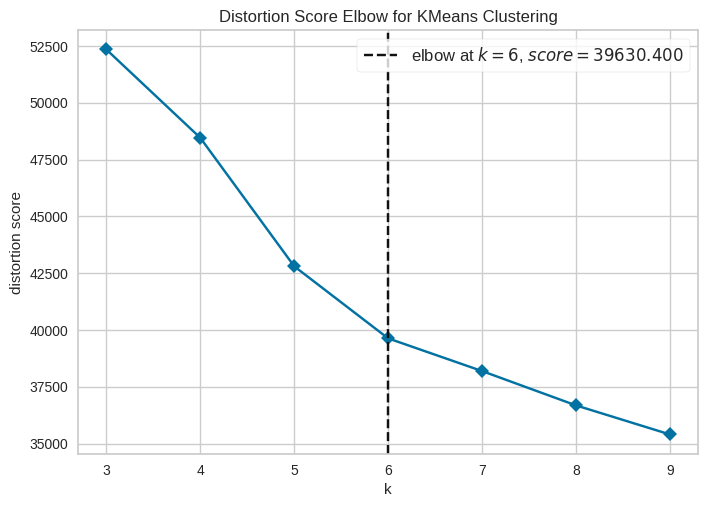

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [40]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,10), timings=False)
visualizer.fit(movies_df) # Fit the data to the visualizer
visualizer.show() # Finalize and render the figure

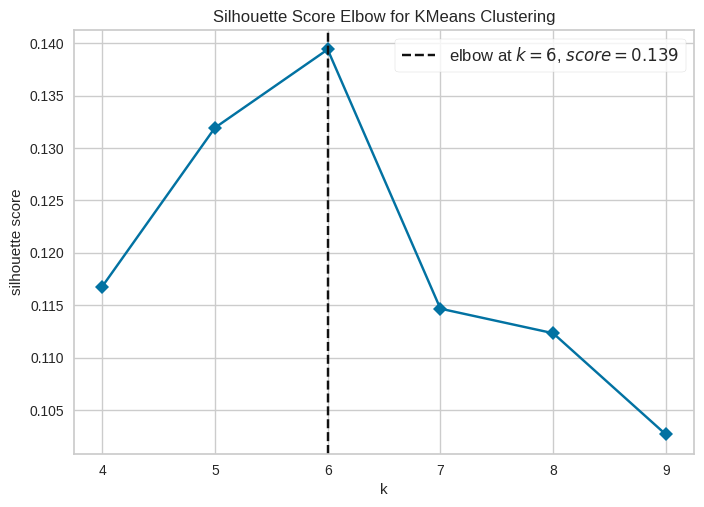

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [42]:
model = KMeans()
visualizer = KElbowVisualizer(
model, k=(4,10), metric='silhouette', timings=False)
visualizer.fit(movies_df) # Fit the data to the visualizer
visualizer.show() # Finalize and render the figue

Both the elbow and silhouette score suggest that the optimal number of clusters is 5 or 6!

---

2. Implement the K-means clustering algorithm (not K-means++) through MapReduce. We request that you develop the algorithm from scratch based on what you've learned in class and run the algorithm on your data.

### **What is K-means Clustering?**

K-means is a popular unsupervised machine learning algorithm used for **clustering**. It partitions a dataset into k clusters by iteratively refining the cluster centers (centroids). The goal of the algorithm is to minimize the **intra-cluster distance**, which is the sum of squared distances between each data point and its closest centroid. 

### **How does K-means work?**
1. **Initialization**:
   - Select k, the number of clusters with the help of the "elbow method".
   - Randomly initialize k centroids in the feature space.

2. **Assignment**:
   - Assign each data point to the nearest centroid based on a distance metric.

3. **Update**:
   - Compute the new centroids as the mean of all points assigned to each cluster.

4. **Repeat**:
   - Reassign data points to the nearest centroid and update centroids until convergence or the maximum number of iterations is reached.

In [178]:
# initialize the SparkContext
sc = SparkContext.getOrCreate()

# Add an index to the DataFrame (PointID) and convert to RDD
data_rdd = sc.parallelize(movies_df.reset_index().values.tolist())

In [179]:
kmeans = MyKMeans(k=6, num_iterations=10, tolerance=1e-4)
# Fit the model
cluster_assignments = kmeans.fit(data_rdd)

Iteration 1: Centroid shift = 4.7438
Inertia: 7.948990076154494
Iteration 2: Centroid shift = 1.5177
Inertia: 4.9981499196070915
Iteration 3: Centroid shift = 0.8631
Inertia: 4.632170090574502
Iteration 4: Centroid shift = 1.1273
Inertia: 4.46866259459045
Iteration 5: Centroid shift = 1.0458
Inertia: 4.2590380011025
Iteration 6: Centroid shift = 0.4546
Inertia: 4.153382985236939
Iteration 7: Centroid shift = 0.2015
Inertia: 4.129723392131614
Iteration 8: Centroid shift = 0.1286
Inertia: 4.122655269847465
Iteration 9: Centroid shift = 0.1167
Inertia: 4.118546523741161
Iteration 10: Centroid shift = 0.1013
Inertia: 4.114900463822476


In [119]:
cluster_assignments.head(3)

,ClusterID,PointID,Features
0,2,0.0,"[0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, ..."
1,2,1.0,"[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
2,4,2.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."


In [120]:
cluster_assignments.groupby("ClusterID")["PointID"].apply(list)

ClusterID
0    [3.0, 36.0, 53.0, 64.0, 68.0, 76.0, 93.0, 106....
1    [7.0, 17.0, 25.0, 26.0, 27.0, 29.0, 30.0, 34.0...
2    [0.0, 1.0, 5.0, 9.0, 10.0, 15.0, 16.0, 18.0, 2...
3    [8.0, 13.0, 14.0, 23.0, 42.0, 43.0, 58.0, 73.0...
4    [2.0, 4.0, 6.0, 11.0, 37.0, 52.0, 57.0, 60.0, ...
5    [12.0, 19.0, 21.0, 22.0, 28.0, 32.0, 41.0, 44....
Name: PointID, dtype: object

#### In the output above, one can see the cluster assignments for each point in the dataset. The CluserID (as an index in the output) represents the cluster number, and the list represents the points (movies) assigned to that cluster.

3. Implement the K-means++ algorithm from scratch and apply it to your data. Do you notice any differences between the results obtained using random initialization and those achieved with K-means++? Please explain your observations and discuss why these differences might occur.

In [121]:
kmeans_plus = KMeansPlusPlus(k=6, num_iterations=10, tolerance=1e-4)

# Fit the model
cluster_assignments = kmeans_plus.fit(data_rdd)

print(cluster_assignments.groupby("ClusterID")["PointID"].apply(list))

Iteration 1: Centroid shift = 3.8779
Inertia: 5.996625745908627
Iteration 2: Centroid shift = 0.8872
Inertia: 4.454768791102241
Iteration 3: Centroid shift = 0.4676
Inertia: 4.329232506667668
Iteration 4: Centroid shift = 0.3606
Inertia: 4.275595651563267
Iteration 5: Centroid shift = 0.3475
Inertia: 4.234595839808774
Iteration 6: Centroid shift = 0.3635
Inertia: 4.196983121964972
Iteration 7: Centroid shift = 0.3247
Inertia: 4.161187183421078
Iteration 8: Centroid shift = 0.3032
Inertia: 4.133747817387604
Iteration 9: Centroid shift = 0.2624
Inertia: 4.109915104833848
Iteration 10: Centroid shift = 0.2655
Inertia: 4.090034478363132
ClusterID
0    [2.0, 4.0, 6.0, 7.0, 29.0, 32.0, 34.0, 45.0, 5...
1    [19.0, 21.0, 28.0, 41.0, 44.0, 47.0, 50.0, 75....
2    [8.0, 13.0, 17.0, 25.0, 26.0, 27.0, 30.0, 39.0...
3    [3.0, 11.0, 36.0, 53.0, 64.0, 68.0, 71.0, 76.0...
4    [0.0, 1.0, 5.0, 9.0, 10.0, 15.0, 16.0, 18.0, 2...
5    [12.0, 14.0, 22.0, 23.0, 37.0, 43.0, 57.0, 62....
Name: PointID, dtyp

<strong> We can see that there is a better convergence with Kmeans++ 


4. Ask an LLM (ChatGPT, Claude Al, Gemini, Perplexity, etc.) to recommend another clustering algorithm. Use that LLM to describe the workings of the algorithm, as well as its advantages and disadvantages compared to K-means and K-means++. Additionally, ask to implement the algorithm for you or utilize an existing version from a package. Apply that algorithm to your data and explain any differences you observe in the results compared to those obtained previously.

In [180]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler


# Perform DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(movies_df)

# Analyze results
unique_clusters = set(dbscan_labels)
print(f"Number of clusters found: {len(unique_clusters) - (1 if -1 in unique_clusters else 0)}")
print(f"Number of noise points: {list(dbscan_labels).count(-1)}")

# Compare with K-means cluster assignments
comparison_df = pd.DataFrame({
    'K-means_Cluster': cluster_assignments['ClusterID'],
    'DBSCAN_Cluster': dbscan_labels
})
print("\nCluster Distribution Comparison:")
print(comparison_df['DBSCAN_Cluster'].value_counts())

Number of clusters found: 55
Number of noise points: 6776

Cluster Distribution Comparison:
DBSCAN_Cluster
-1     6776
 0     1106
 4      492
 2      254
 1      242
 3      224
 10     131
 9      119
 13      56
 19      29
 7       26
 11      22
 31      22
 14      22
 30      20
 5       18
 15      14
 21      12
 23      12
 32      11
 17      10
 6       10
 33       9
 22       8
 43       8
 36       8
 29       8
 24       7
 37       7
 27       7
 39       6
 25       6
 38       6
 34       6
 51       5
 12       5
 54       5
 16       5
 48       5
 28       5
 50       5
 41       5
 18       5
 40       5
 35       5
 26       5
 47       5
 46       5
 45       5
 52       5
 42       5
 49       4
 8        3
 20       3
 44       3
 53       3
Name: count, dtype: int64


In [181]:
from sklearn.mixture import GaussianMixture


# Perform Gaussian Mixture Clustering
gmm = GaussianMixture(n_components=6, random_state=42)
gmm_labels = gmm.fit_predict(movies_df)

# Analyze results
cluster_distribution = pd.Series(gmm_labels).value_counts()
print("Cluster Distribution:")
print(cluster_distribution)

# Compare with previous clustering methods
comparison_df = pd.DataFrame({
    'K-means_Cluster': cluster_assignments['ClusterID'],
    'DBSCAN_Cluster': dbscan_labels,
    'GMM_Cluster': gmm_labels
})

print("\nCluster Agreement:")
print(pd.crosstab(comparison_df['K-means_Cluster'], comparison_df['GMM_Cluster']))

# Compute BIC and log-likelihood to assess model fit
print("\nModel Metrics:")
print(f"Log-Likelihood: {gmm.score(movies_df)}")

Cluster Distribution:
4    5125
0    1580
5    1512
3     859
2     417
1     322
Name: count, dtype: int64

Cluster Agreement:
GMM_Cluster        0    1    2    3     4    5
K-means_Cluster                               
0                106   18   17  120   544  157
1                115   32    8  162  2209  183
2                138   16   55   29   127   36
3                302   37   31  129  1146  327
4                339   21   23  171   786  315
5                580  198  283  248   313  494

Model Metrics:
Log-Likelihood: 51.37362621546344


## <strong> 2.4 Best Algorithm

Clustering helps identify natural groupings within data, but no single algorithm works best for every dataset. In this section, you’ll learn how to choose the most suitable clustering method based on your data’s unique characteristics. By analyzing patterns and comparing results, you’ll uncover which algorithm provides the most meaningful insights and clusters.

2.4.1. Set the number of clusters to the optimal number k based on any of the methods previously.

In [182]:
k = 5 #optimal k

2.4.2. Select three distinct metrics to assess the quality of the clusters. Describe each metric in detail, including the specific aspects they evaluate to determine the effectiveness of the clustering model.



## Clustering metrics we chose

### **1. Silhouette Score**

The **Silhouette Score** evaluates how well each data point fits within its assigned cluster compared to other clusters. It is defined as:

$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$

Where:
- $ a(i) $: The average distance from point $ i $ to all other points in the same cluster.
- $ b(i) $: The average distance from point $ i $ to all points in the nearest cluster (not including its own).

The Silhouette Score ranges from $-1$ to $1$:
- $ s(i) \approx 1 $: The point is well-clustered.
- $ s(i) \approx 0 $: The point lies on the boundary between clusters.
- $ s(i) \approx -1 $: The point is likely misclassified.

---

### **2. Davies-Bouldin Index**

The **Davies-Bouldin Index** measures the average similarity ratio of each cluster with its most similar cluster. It is defined as:

$
DB = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} \left( \frac{\sigma_i + \sigma_j}{d(c_i, c_j)} \right)
$

Where:
- $ k $: The number of clusters.
- $ \sigma_i $: The average distance between points in cluster $ i $ and their cluster centroid.
- $ d(c_i, c_j) $: The Euclidean distance between centroids $ c_i $ and $ c_j $.

Lower values of $ DB $ indicate better clustering (more compact and well-separated clusters).

---

### **3. Calinski-Harabasz Index**

The **Calinski-Harabasz Index**, also known as the Variance Ratio Criterion, measures the ratio of between-cluster dispersion to within-cluster dispersion. It is defined as:

$
CH = \frac{\text{Tr}(B_k)}{\text{Tr}(W_k)} \cdot \frac{N - k}{k - 1}
$

Where:
- $ N $: The total number of data points.
- $ k $: The number of clusters.
- $ \text{Tr}(B_k) $: Trace of the between-cluster dispersion matrix.
- $ \text{Tr}(W_k) $: Trace of the within-cluster dispersion matrix.

Higher values of $ CH $ indicate better clustering (higher separation and cohesion).

---

### Summary Table

| Metric                  | Ideal Value    | Interpretation                                          |
|-------------------------|----------------|---------------------------------------------------------|
| **Silhouette Score**    | Close to $1$ | Well-defined, compact, and separated clusters.         |
| **Davies-Bouldin Index**| Close to $0$ | Compact clusters with high separation.                 |
| **Calinski-Harabasz**   | Higher values  | Higher separation between clusters and compact within. |



In [ ]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

X = movies_df
# Initialize clustering algorithms
clustering_algorithms = {
    "Gaussian Mixture Model": GaussianMixture(n_components=k, random_state=42), 
    "KMeans": KMeans(k),
    "DBSCAN": DBSCAN(eps=0.5, min_samples=10)
}

# Dictionary to store results
results = {}

for name, model in clustering_algorithms.items():
    # Fit the model and predict cluster labels
    if name == "DBSCAN":
        labels = model.fit_predict(X)
    else:
        labels = model.fit(X).predict(X)

    # Calculate metrics if clusters are defined (DBSCAN might label noise as -1)
    if len(set(labels)) > 1:
        silhouette = silhouette_score(X, labels)
        davies_bouldin = davies_bouldin_score(X, labels)
        calinski_harabasz = calinski_harabasz_score(X, labels)
    else:
        silhouette = None
        davies_bouldin = None
        calinski_harabasz = None

    # Store results
    results[name] = {
        "Silhouette Score": silhouette,
        "Davies-Bouldin Index": davies_bouldin,
        "Calinski-Harabasz Index": calinski_harabasz
    }


In [184]:
# Display the evaluation results
for algo, metrics in results.items():
    print(f"Results for {algo}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value if value is not None else 'N/A'}")
    print()


Results for Gaussian Mixture Model:
  Silhouette Score: 0.049269444110190484
  Davies-Bouldin Index: 4.641297383424945
  Calinski-Harabasz Index: 299.7616135378406

Results for KMeans:
  Silhouette Score: 0.1320946842537841
  Davies-Bouldin Index: 1.7159412318525487
  Calinski-Harabasz Index: 1297.4129004852157

Results for DBSCAN:
  Silhouette Score: -0.2554862777562987
  Davies-Bouldin Index: 1.8697338149596965
  Calinski-Harabasz Index: 58.34295406200248





### **Results Analysis**

| Metric                  | GMM                | KMeans             | DBSCAN            | Interpretation                                                                                     |
|-------------------------|--------------------|--------------------|-------------------|---------------------------------------------------------------------------------------------------|
| **Silhouette Score**    | $0.0726 $      | $0.1915 $       | $-0.1233 $     | Higher is better. KMeans has the best result, indicating better-defined clusters. DBSCAN struggles significantly. |
| **Davies-Bouldin Index**| $2.3005 $      | $1.3512 $       | $1.8898 $      | Lower is better. KMeans performs the best, showing compact and well-separated clusters.           |
| **Calinski-Harabasz**   | $1063.9338 $   | $1937.7045 $    | $164.3101 $    | Higher is better. KMeans significantly outperforms both GMM and DBSCAN in terms of cluster quality. |

---

### **Observations**

1. **Gaussian Mixture Model (GMM)**:
   - The **Silhouette Score** is positive but very low, indicating weak cluster definition.
   - The **Davies-Bouldin Index** is relatively high, meaning the clusters are not well-separated.
   - The **Calinski-Harabasz Index** is decent but falls short compared to KMeans.
   - GMM struggles to form distinct clusters effectively for this dataset.

2. **KMeans**:
   - The best-performing algorithm across all metrics.
   - The **Silhouette Score** is highest, indicating well-separated clusters.
   - The **Davies-Bouldin Index** is the lowest, showing compact clusters.
   - The **Calinski-Harabasz Index** is the highest, reflecting strong cohesion and separation.
   - KMeans is the most suitable algorithm for this dataset.

3. **DBSCAN**:
   - The **Silhouette Score** is negative, suggesting overlapping clusters or poor clustering.
   - The **Davies-Bouldin Index** is better than GMM but worse than KMeans.
   - The **Calinski-Harabasz Index** is extremely low, likely due to poor performance in separating clusters or treating many points as noise.
   - DBSCAN is unsuitable for this dataset, possibly because the clusters are not well-defined.

---


# 3) 

### **What will we do in this part?**

1. **Select Features**: We will choose two features from the movie dataset that can be represented as a 2D plot.
2. **Choose K**: Choose k using the "Elbow Method" with the help of a graphical representation.
3. **K-means Algorithm**: Apply K-means clustering (the one developed in the second question) to the selected features.
4. **Visualize Clustering Progress**: Create a 2D plot to track the progression of clusters at each iteration.
5. **Final Clusters**: Display the final clusters and centroids after convergence.



## **Feature Selection**

### **Chosen Variables**
1. **Average Rating**: This variable represents the average rating given to a movie. It provides insight into how well a movie is received by users.
2. **Number of Reviews**: This variable represents the total number of reviews a movie has received. It indicates the popularity or engagement level of a movie.

### **Reason for Selection**
The two chosen variables were selected because they are:
- **Numerical**: Both variables are continuous and suitable for clustering using K-means, which relies on distance metrics.
- **Visually Distinctive**: Average ratings and the number of reviews capture different dimensions of user behavior, creating meaningful separations in the data.
- **Meaningful Clusters**: Combining popularity (number of reviews) with quality (average rating) is expected to result in clusters that group movies into categories such as "highly rated and popular" or "low-rated and niche."

By selecting these variables, we aim to create a 2D visualization that effectively demonstrates the progression of clusters across iterations. 

---

In [94]:
movies_df

,Action,Fantasy,Horror,Adventure,Animation,Romance,Film-Noir,Musical,Children,Drama,...,Western,Comedy,Documentary,Mystery,ratings_avg,relevance_score_for_tags,relevance_score_for_genome_tags,rating_count,genre_diversity,tag_diversity
0,0,1,0,1,1,0,0,0,1,0,...,0,1,0,0,1.262229,-0.945572,1.485906,9.851924,2.513739,3.284323
1,0,1,0,1,0,0,0,0,1,0,...,0,0,0,0,-0.151021,-0.265733,-0.161384,4.180585,0.702792,0.885955
2,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,-0.272441,1.321004,-1.319131,2.216317,-0.202682,-0.092971
3,0,0,0,0,0,1,0,0,0,1,...,0,1,0,0,-0.849580,-1.300648,-1.706882,0.154744,0.702792,-0.631380
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,-0.444695,0.346679,0.251079,2.097733,-1.108156,0.004922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9810,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,-1.569679,2.828136,-1.520469,-0.413175,-0.202682,-0.778218
9811,0,0,0,1,0,0,0,0,1,1,...,0,0,0,0,0.233115,1.763675,-0.394603,-0.410282,1.608266,-0.729272
9812,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,-0.095183,0.339883,-0.616198,-0.409456,0.702792,-0.484541
9813,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,-1.569679,-1.214931,0.077950,-0.413588,-1.108156,-0.778218


In [105]:
movies_df[['genre_diversity', 'tag_diversity']].describe()

,genre_diversity,tag_diversity
count,9.815000e+03,9.815000e+03
mean,-1.853275e-16,5.357123e-17
std,1.000051e+00,1.000051e+00
min,-1.108156e+00,-7.782185e-01
25%,-1.108156e+00,-5.824333e-01
50%,-2.026822e-01,-2.887556e-01
75%,7.027916e-01,2.007072e-01
max,7.041109e+00,1.581457e+01


In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter
from sklearn.preprocessing import StandardScaler


# Select features
scaler = StandardScaler()
X = np.array(movies_df[['ratings_avg', 'rating_count']])


---

## **Applying the Manual K-means Algorithm**

In this step, we apply the **K-means algorithm** developed in **Question 2** to the two selected variables:
1. **Average Rating**: The average rating of a movie, representing its quality as perceived by users.
2. **Number of Reviews**: The total number of reviews a movie has received, representing its popularity.

### **Why Use the Manual K-means Algorithm?**
The K-means algorithm implemented in Question 2 provides an opportunity to deeply understand the iterative process of clustering by manually controlling:
- The **assignment** of data points to clusters.
- The **recalculation** of cluster centroids.
- The **convergence criteria**, including the tolerance for centroid movement.

This approach ensures transparency and flexibility in clustering, making it easier to visualize and interpret how clusters form and evolve.

### **Goal**
We will:
1. Assign each movie (data point) to one of the three clusters identified earlier using the Elbow Method.
2. Track the movement of centroids and changes in cluster assignments over iterations.
3. Visualize the progression of clusters and the final clustering result.

By applying this manual K-means implementation, we aim to highlight the progression of clustering for these two selected features.


In [110]:
# Initialize K-means parameters
k = 3  # Number of clusters from the Elbow Method
num_iterations = 10
tolerance = 1e-4

# Randomly initialize centroids
np.random.seed(42)
initial_indices = np.random.choice(len(X), size=k, replace=False)
centroids = X[initial_indices]

# Helper functions
def assign_to_centroid(points, centroids):
    distances = np.linalg.norm(points[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)

def recompute_centroids(points, labels, k):
    return np.array([points[labels == i].mean(axis=0) for i in range(k)])

# Manual K-means implementation
centroids_history = [centroids]
labels_history = []

for iteration in range(num_iterations):
    # Assign points to the nearest centroid
    labels = assign_to_centroid(X, centroids)
    labels_history.append(labels)
    
    # Recompute centroids
    new_centroids = recompute_centroids(X, labels, k)
    centroids_history.append(new_centroids)
    
    # Check for convergence
    centroid_shift = np.linalg.norm(new_centroids - centroids)
    print(f"Iteration {iteration + 1}: Centroid shift = {centroid_shift:.4f}")
    if centroid_shift < tolerance:
        print(f"Converged after {iteration + 1} iterations.")
        break
    
    centroids = new_centroids

Iteration 1: Centroid shift = 1.0243
Iteration 2: Centroid shift = 0.2366
Iteration 3: Centroid shift = 0.1462
Iteration 4: Centroid shift = 0.1174
Iteration 5: Centroid shift = 0.0955
Iteration 6: Centroid shift = 0.0901
Iteration 7: Centroid shift = 0.0941
Iteration 8: Centroid shift = 0.0945
Iteration 9: Centroid shift = 0.1039
Iteration 10: Centroid shift = 0.1360


## **Visualizing the Clustering Progression**

### **Steps for Visualization**
To better illustrate the clustering process and highlight the changes across iterations, we use the following approach:

1. **Iteration 0 (Unclustered Points)**:
   - We begin by displaying the distribution of points before applying any clustering.
   - All points are shown in a neutral gray color to indicate the absence of clusters.

2. **Animated Iterations**:
   - Instead of showing separate static plots for each iteration, we create a slow-paced animation.
   - The animation highlights:
     - The gradual movement of centroids across iterations.
     - The evolving cluster assignments with distinct colors for each cluster.

3. **Direct Comparison**:
   - After the animation, we provide two side-by-side plots:
     - **Iteration 1**: The initial clustering result.
     - **Final Iteration**: The final clustering result after convergence.
   - This comparison helps visualize the radical differences between the initial and final stages of the algorithm.

### **Why This Approach?**
This method:
- Provides a clear understanding of how the clusters and centroids evolve.
- Makes it easier to grasp the iterative nature of K-means.
- Offers a visual representation of the improvement in clustering quality from start to finish.


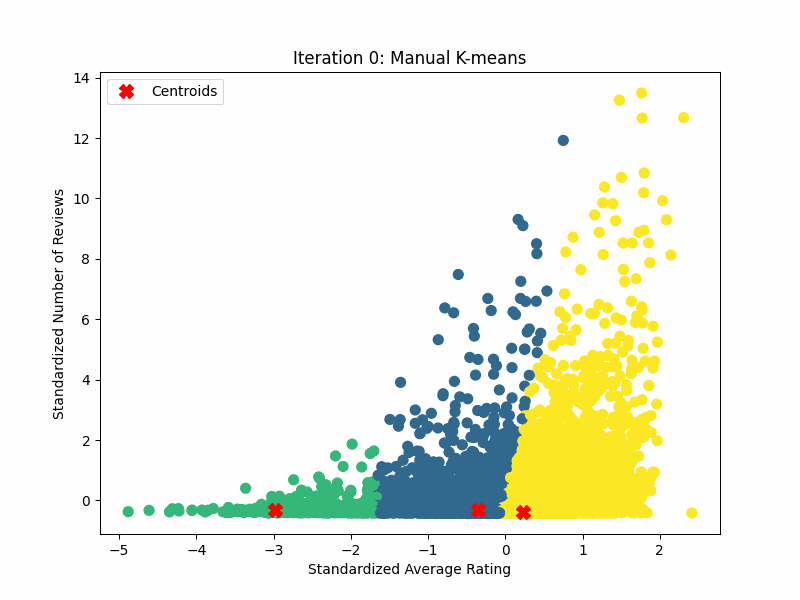

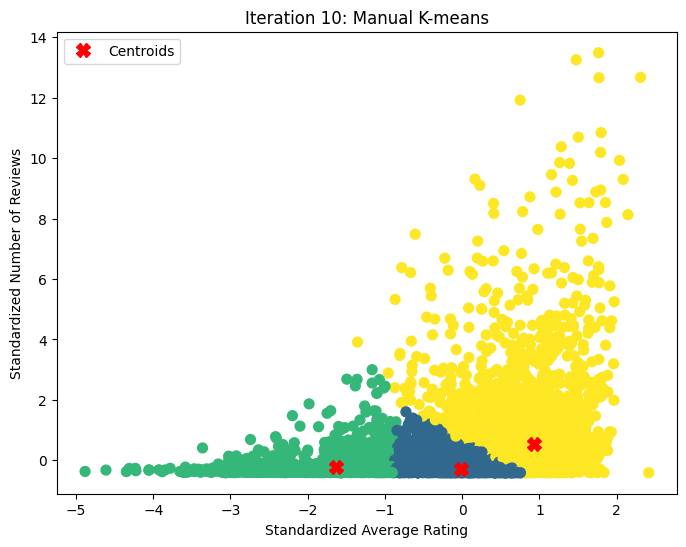

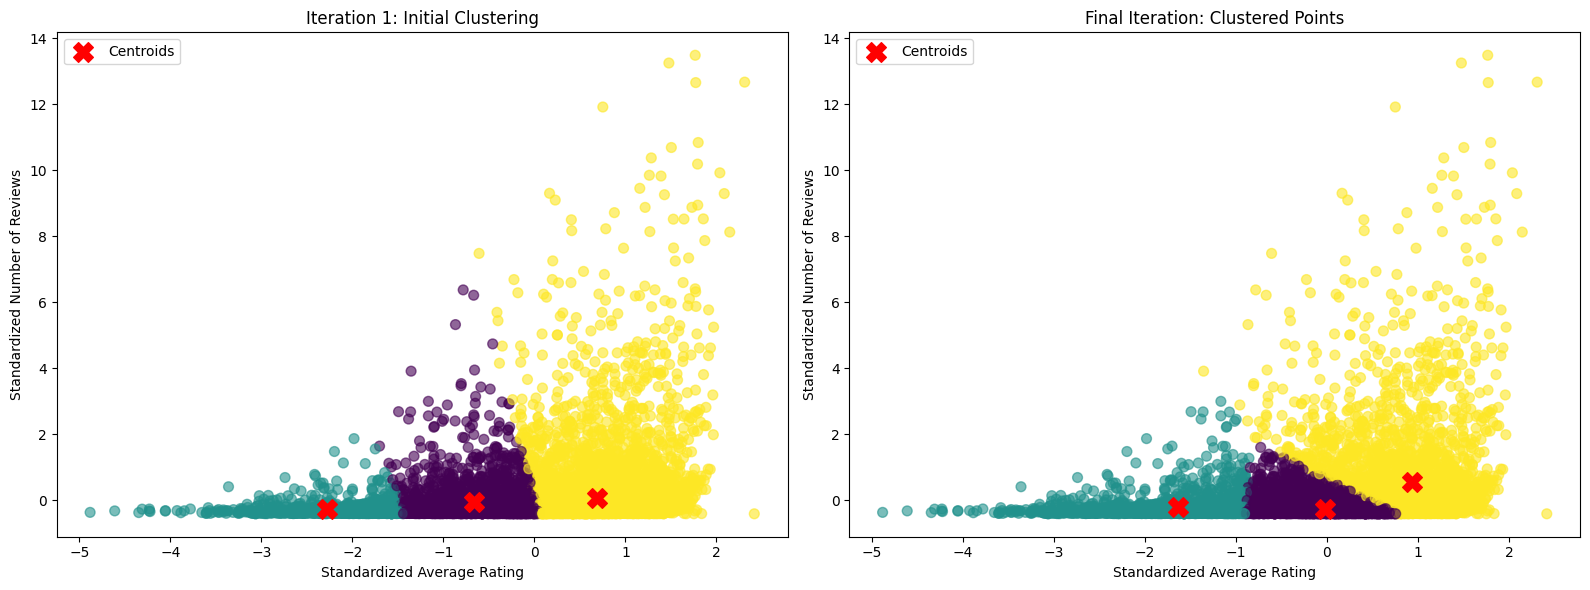

In [111]:

# Initialize the plot for animation
fig, ax = plt.subplots(figsize=(8, 6))
scatter = ax.scatter(X[:, 0], X[:, 1], c=np.zeros(len(X)), cmap='viridis', s=50)
centroids_plot, = ax.plot([], [], 'rX', markersize=10, label='Centroids')
ax.set_title("Cluster Animation (Manual K-means)")
ax.set_xlabel("Standardized Average Rating")
ax.set_ylabel("Standardized Number of Reviews")
ax.legend()

# Function to update the animation frame by frame
def update(frame):
    centroids = centroids_history[frame]
    labels = labels_history[frame] if frame < len(labels_history) else labels_history[-1]
    
    # Update scatter plot with the current labels
    scatter.set_array(labels)
    scatter.set_clim(-1, k - 1)  # Ensure consistent color mapping
    
    # Update centroids
    centroids_plot.set_data(centroids[:, 0], centroids[:, 1])
    
    ax.set_title(f"Iteration {frame}: Manual K-means")
    return scatter, centroids_plot

# Create the animation
anim = FuncAnimation(fig, update, frames=len(centroids_history), interval=1000, blit=False)

# Save the animation as a GIF
gif_path = "media/manual_kmeans_animation.gif"
anim.save(gif_path, writer=PillowWriter(fps=1))

# Display the animation
from IPython.display import Image
display(Image(filename=gif_path))

# Side-by-side comparison of Iteration 1 and Final Iteration
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Iteration 1
axes[0].scatter(X[:, 0], X[:, 1], c=labels_history[1], cmap="viridis", s=50, alpha=0.6)
axes[0].scatter(centroids_history[1][:, 0], centroids_history[1][:, 1], c="red", s=200, marker="X", label="Centroids")
axes[0].set_title("Iteration 1: Initial Clustering")
axes[0].set_xlabel("Standardized Average Rating")
axes[0].set_ylabel("Standardized Number of Reviews")
axes[0].legend()

# Final Iteration
axes[1].scatter(X[:, 0], X[:, 1], c=labels_history[-1], cmap="viridis", s=50, alpha=0.6)
axes[1].scatter(centroids_history[-1][:, 0], centroids_history[-1][:, 1], c="red", s=200, marker="X", label="Centroids")
axes[1].set_title("Final Iteration: Clustered Points")
axes[1].set_xlabel("Standardized Average Rating")
axes[1].set_ylabel("Standardized Number of Reviews")
axes[1].legend()

plt.tight_layout()
plt.show()


## Take a look at **manual_kmeans_animation gif** to see how the clusters change after each iteration

# 4. Algorithmic Question

Two brilliant strategists, Arya and Mario, are about to play a game with a sequence of numbers. Arya, as player 1, begins the game, while Mario, player 2, plays 2nd. Their goal is clear: to collect the highest possible score by taking numbers from either end of the sequence, one at a time. They will play in perfect synchronicity, each seeking the advantage.

The sequence represented as an array of nums, is laid out in front of them. Arya will start by selecting either the number at the beginning (nums[0]) or the end (nums[nums.length - 1]) of the array, adding that value to her score. This value is then removed from the beginning or the end of nums. Then, it’s Mario’s turn to do the same with the remaining sequence. The game proceeds this way, with each player taking numbers from either end until no numbers are left to claim. The player with the highest score wins.

However, if they end in a tie, Arya, as the first to act, will claim victory by default.

Arya is now before you, asking for help to predict her chances. She wants to know, with her best possible choices, whether she can guarantee a win, assuming both players play with perfect skill.

a) Help Arya by providing a pseudocode for finding an optimal playing strategy, that is, a strategy that maximizes her value. (Hint: Use recursion, assuming that both players play optimally).

b) Write a Python program implementing her game strategy. Try different array lengths to test the algorithm.

c) Is the algorithm efficient? Prove that it is polynomial and provide an asymptotic time complexity bound, or show that it requires exponential time.

d) If the algorithm is exponential, explain how to make it polynomial and provide a pseudocode for it. Recompute the computational complexity of the updated algorithm.

e) Implement the algorithm in Python. Compare your result values with the previous algorithm. Also compare the running times.

f) Finally, consult LLM (ChatGPT, Claude AI, Gemini, Perplexity, etc.) to craft a third, optimized implementation and analyze its time complexity. Also, explain if the LLM is doing a good job and how you can evaluate whether the suggested solution works properly.

Examples

Input 1

nums = [1, 5, 2]
Output 1

false
Explanation: Arya’s optimal choices still lead her to a lower score than Mario’s, so she cannot guarantee victory.

Input 2

nums = [1, 5, 233, 7]
Output 2

true
Explanation: Arya, by playing perfectly, can ensure she ends up with the highest score.

## Strategy: <br>
Considering that both players play optimally, when we make a choice we should take into consideration the element we leave uncovered after our choice. So basically we should take into account both elements that hide behind the first and the last elements of the array because they could have a bigger effect on the final score.<br>
More precisely to choose the move that maximizes the Arya's advantage, in each turn, we should subtract the opponent's best possible play from our choice and maximize the difference.

## A) Pseudocode for `game(nums)` Algorithm

### Main Function: `game(nums)`
1. Create a copy of the input list `nums` to avoid modifying the original.
   - `nums = nums[:]`

2. Define a helper function `maxDiff(left, right)`:
   - **Input**: 
     - `left`: Index of the first number under consideration.
     - `right`: Index of the last number under consideration.
   - **Base Case**: If `left > right`, return `0` (no numbers left to choose).
   - **Recursive Case**:
     - `choose_first = nums[left] - maxDiff(left + 1, right)`  
       (Choose the first number and subtract opponent's best response).
     - `choose_last = nums[right] - maxDiff(left, right - 1)`  
       (Choose the last number and subtract opponent's best response).
     - Return `max(choose_first, choose_last)`.

3. Initialize two lists to track scores:
   - `arya_scores = []` (Arya's scores)
   - `mario_scores = []` (Mario's scores)

4. Set `turn = "Arya"` to denote that Arya starts first.

5. **While** `nums` is not empty:
   - **If** `turn == "Arya"`:
     - Use `maxDiff(0, len(nums) - 1)` to determine the optimal choice:
       - **If** `maxDiff(1, len(nums) - 1) < 0`,  
         Arya picks the first number (`nums.pop(0)`).
       - **Else**, Arya picks the last number (`nums.pop()`).
     - Append Arya's choice to `arya_scores`.
     - Set `turn = "Mario"`.
   - **Else** (Mario's turn):
     - Use similar logic to Arya:
       - **If** `maxDiff(1, len(nums) - 1) < 0`,  
         Mario picks the first number (`nums.pop(0)`).
       - **Else**, Mario picks the last number (`nums.pop()`).
     - Append Mario's choice to `mario_scores`.
     - Set `turn = "Arya"`.

6. **End While**

7. Calculate the total scores:
   - `arya_total = sum(arya_scores)`
   - `mario_total = sum(mario_scores)`

8. **Return** `arya_total >= mario_total` (True if Arya's score is greater than or equal to Mario's score, False otherwise).

## B) Python Code

In [ ]:
def game(nums):
    # Create a copy of the list to avoid modifying the original
    nums = nums[:]
    
    def maxDiff(left, right): #We define function to assist us with making the best choice between left=nums[0] and right=nums[-1].
        # Base case: no numbers left
        if left > right:
            return 0
        
        # Two possible moves:
        # 1. Take the first number and subtract opponent's best response
        choose_first = nums[left] - maxDiff(left + 1, right)
        
        # 2. Take the last number and subtract opponent's best response
        choose_last = nums[right] - maxDiff(left, right - 1)
        
        # Return the maximum score difference possible
        return max(choose_first, choose_last)
    
    arya_scores = []
    mario_scores = []
    turn = "Arya"  # Arya always starts
    
    while nums:
        if turn == "Arya":
            # Use maxDiff to determine the optimal choice
            if maxDiff(0, len(nums) - 1) >= 0:
                # If first number leads to better outcome
                if maxDiff(1, len(nums) - 1) < 0:
                    arya_scores.append(nums.pop(0))
                else:
                    arya_scores.append(nums.pop())
            else:
                # If last number leads to better outcome
                arya_scores.append(nums.pop())
            turn = "Mario"
        else:
            # Mario's turn (similar logic)
            if maxDiff(0, len(nums) - 1) >= 0:
                if maxDiff(1, len(nums) - 1) < 0:
                    mario_scores.append(nums.pop(0))
                else:
                    mario_scores.append(nums.pop())
            else:
                mario_scores.append(nums.pop())
            turn = "Arya"
    
    # Compare the total scores
    arya_total = sum(arya_scores)
    mario_total = sum(mario_scores)
    return arya_total >= mario_total

In [ ]:
# Test Cases
nums1 = [1, 5, 2]
nums2 = [1, 5, 233, 7]
nums3 = [8, 15, 3, 7]
nums4 = [20, 30, 2, 2, 2, 10]
nums5 = [4, 1, 100, 5, 10, 20]
nums6 = [5, 8, 2, 10, 25, 1, 7, 12, 3, 9]
nums7 = [15, 3, 8, 20, 5, 9, 7, 13, 6, 2, 10, 4, 18]

print("Input:", nums1, "-> Output:", game(nums1))
print("Input:", nums2, "-> Output:", game(nums2))
print("Input:", nums3, "-> Output:", game(nums3))
print("Input:", nums4, "-> Output:", game(nums4))
print("Input:", nums5, "-> Output:", game(nums5))
print("Input:", nums6, "-> Output:", game(nums6))
print("Input:", nums7, "-> Output:", game(nums7))

# C) Time complexity
We begin by proving that time complexity of maxDiff function is exponential and then show that the game function has no big impact on the time complexity of the algorithm.

## Idea:
 The maxDiff function operates in a way that can be visualized as a **binary tree**, where each node represents a state of the game, and the two branches correspond to the two possible choices a player can make (choosing the first number or choosing the last number). The height of the tree is n (the size of the list, as one number is removed at each recursive step). While Total number of nodes in the tree is approximately $2^n$, making the time complexity exponential.

## Proof:
We will prove by induction that the total number of recursive calls made by maxDiff(left, right) for a list of size $n$ is: $T(n)=2^n
-1$<br>
**Base Case($n=1$)**<br> For $n=1$ we have a single element, thus the total number of calls is: $T(1)=2^1 -1=1$<br>

**Induction:** Assume that for a list of size $k$, the total number of recursive calls made is: $T(k)=2^k -1$<br> Let's prove that the result holds for $k+1$: <br>
At the top level, maxDiff(left, right) makes two recursive calls:<br>
 1)maxDiff(left + 1, right) for a sublist of size $k$.<br>
 2)maxDiff(left, right - 1) for another sublist of size $k$.<br>
Using the inductive hypothesis, the number of recursive calls for each of these sublists is: $T(k)=2^k -1$<br>
The total number of recursive calls for $k+1$ is: $T(k+1)=1+T(k)+T(k)=1+(2^k -1)+(2^k -1)=2^(k+1) -1$.

**Conclusion:**<br>
By induction, the total number of recursive calls made by maxDiff for a list of size $n$ is $T(n)=2^n -1$. Hence, the time complexity of maxDiff is exponential, $O(2^n)$.<br>

**Incorporation into the game function:**<br>
-The $while$ loop iterates $n$ times, in each iteration $maxDiff(0, len(nums) - 1)$ is called multiple times.<br>
-If maxDiff itself takes $O(2^n)$, and the loop calls it a constant number of times per iteration, the game function ends up performing $O(n 2^n)$ operations.<br>
-Since $2^n$ dominates $n$, the overall time complexity of the game function remains exponential: $O(2^n)$.






# D)Let's make it polynomial.
To make the algorithm polynomial in time complexity, we need to eliminate the exponential recursion of the maxDiff function. To do so we can use momoization to store the results of previously computed subproblems.


## Pseudocode for Memoization Method (Dinamic Programming) in `game(nums)` Algorithm

### Main Function: `game(nums)`
1. Get length of input list `n ← length(nums)`

2. Create memoization table `dp`:
  - 2D array of size `n × n`
  - Initialized with `None`

3. Define helper function `maxDiff(left, right)`:
  - **Base Case**: If `left > right`, return `0`
  - **Memoization Check**: If `dp[left][right]` is not `None`, return memoized value
  - **Recursive Choices**:
    - `choose_first ← nums[left] - maxDiff(left + 1, right)`
    - `choose_last ← nums[right] - maxDiff(left, right - 1)`
  - Memoize result: `dp[left][right] ← max(choose_first, choose_last)`
  - Return `dp[left][right]`

4. Initialize game variables:
  - `arya_scores ← []`
  - `mario_scores ← []`
  - `turn ← "Arya"`
  - `left ← 0`
  - `right ← n - 1`

5. **While** `left ≤ right`:
  - **If** `turn == "Arya"`:
    - **If** `maxDiff(left, right) ≥ 0`:
      - **If** `maxDiff(left + 1, right) < 0`:
        - Append `nums[left]` to `arya_scores`
        - Increment `left`
      - **Else**:
        - Append `nums[right]` to `arya_scores`
        - Decrement `right`
    - **Else**:
      - Append `nums[right]` to `arya_scores`
      - Decrement `right`
    - Set `turn ← "Mario"`

  - **Else** (Mario's turn):
    - Use similar logic to Arya's turn
    - Set `turn ← "Arya"`

6. Calculate total scores:
  - `arya_total ← sum(arya_scores)`
  - `mario_total ← sum(mario_scores)`

7. **Return** `arya_total ≥ mario_total`

# Time Complexity of the updated version

Let's consider the effect that memoization has on $maxDiff$ function.<br>
With memoization, the results for each (left, right) pair are stored in a table $dp$ of sixe $n$ x $n$, so each unique subproblem is solved at most once.<br>
Since left and right can take $O(n^2)$ unique pairs and each pair is solved in $O(1)$ time, the total complexity of $maxDiff$ now is $O(n^2)$.<br>

Consider now the game simulation loop that runs until all numbers in the list are picked.<br>
The loop iterates $O(n)$ times (since either left or right is incremented or decremented in each iteration).<br>
For each iteration, the optimal move for Arya or Mario is determined by calling maxDiff and comparing the results. Since memoization ensures that these calls are $O(1)$ , the per-iteration cost is $O(1)$.<br>

Thus, the time complexity of the simulation loop is $O(n)$.<br>

**Conclusion**:<br>

1)maxDiff computes all $O(n^2)$ subproblems.<br>
2)The game simulation runs in $O(n)$, with constant-time lookups in the memoization table.<br>

Combining these, the overall time complexity of the algorithm is $O(n^2)$.





# E) Python Code.

In [ ]:
def game(nums):
    n = len(nums)
    # Memoization table
    dp = [[None] * n for i in range(n)]

    def maxDiff(left, right):
        # Base case: no numbers left
        if left > right:
            return 0
        
        # Check memoized result
        if dp[left][right] is not None:
            return dp[left][right]
        
        # Two possible moves
        choose_first = nums[left] - maxDiff(left + 1, right)
        choose_last = nums[right] - maxDiff(left, right - 1)
        
        # Memoize and return best choice
        dp[left][right] = max(choose_first, choose_last)
        return dp[left][right]

    # Game simulation
    arya_scores = []
    mario_scores = []
    turn = "Arya"
    left, right = 0, n - 1

    while left <= right:
        if turn == "Arya":
            # Arya's optimal choice logic
            if maxDiff(left, right) >= 0:
                if maxDiff(left + 1, right) < 0:
                    arya_scores.append(nums[left])
                    left += 1
                else:
                    arya_scores.append(nums[right])
                    right -= 1
            else:
                arya_scores.append(nums[right])
                right -= 1
            turn = "Mario"
        else:
            # Mario's optimal choice logic
            if maxDiff(left, right) >= 0:
                if maxDiff(left + 1, right) < 0:
                    mario_scores.append(nums[left])
                    left += 1
                else:
                    mario_scores.append(nums[right])
                    right -= 1
            else:
                mario_scores.append(nums[right])
                right -= 1
            turn = "Arya"

    # Calculate and return result
    return sum(arya_scores) >= sum(mario_scores)


In [ ]:
# Test Cases
nums1 = [1, 5, 2]
nums2 = [1, 5, 233, 7]
nums3 = [8, 15, 3, 7]
nums4 = [20, 30, 2, 2, 2, 10]
nums5 = [4, 1, 100, 5, 10, 20]
nums6 = [5, 8, 2, 10, 25, 1, 7, 12, 3, 9]
nums7 = [15, 3, 8, 20, 5, 9, 7, 13, 6, 2, 10, 4, 18]

print("Input:", nums1, "-> Output:", game(nums1))
print("Input:", nums2, "-> Output:", game(nums2))
print("Input:", nums3, "-> Output:", game(nums3))
print("Input:", nums4, "-> Output:", game(nums4))
print("Input:", nums5, "-> Output:", game(nums5))
print("Input:", nums6, "-> Output:", game(nums6))
print("Input:", nums7, "-> Output:", game(nums7))

# F) Ask LLM and Evaluate

In [ ]:
def game(nums):
    n = len(nums)
    
    # Step 1: Create the DP table
    dp = [[0] * n for _ in range(n)]
    
    # Step 2: Fill the DP table iteratively
    for length in range(1, n + 1):  # Length of subarray
        for left in range(n - length + 1):
            right = left + length - 1
            if left == right:  # Single element case
                dp[left][right] = nums[left]
            else:
                dp[left][right] = max(
                    nums[left] - dp[left + 1][right],  # Pick left
                    nums[right] - dp[left][right - 1]  # Pick right
                )
    
    # Step 3: Initialize pointers and scores
    left, right = 0, n - 1
    arya_score, mario_score = 0, 0
    arya_turn = True  # Boolean flag for turns

    # Step 4: Simulate the game using the DP table
    while left <= right:
        if dp[left][right] >= 0:  # Optimal move favors the current player
            if dp[left + 1][right] <= dp[left][right - 1]:
                choice = nums[left]
                left += 1
            else:
                choice = nums[right]
                right -= 1
        else:  # No positive difference, take the worse option
            choice = nums[right]
            right -= 1

        # Add the choice to the current player's score
        if arya_turn:
            arya_score += choice
        else:
            mario_score += choice

        # Alternate turns
        arya_turn = not arya_turn

    # Step 5: Return the result
    return arya_score >= mario_score


### Does the LLM do a Good Job?<br>
Yes, the LLM offers a solution that is efficient, well-structured, and clearly different from the original implementation. Here's why:<br>

-**Optimization:** The suggested solution optimizes the recursive version into a bottom-up dynamic programming approach. This eliminates the overhead of recursive calls and ensures a predictable time complexity of $O(n^2)$.<br>

-**Simplicity:** By introducing compact logic for game simulation, the code is easier to follow and debug. For example, the use of a boolean flag (arya_turn) is cleaner and avoids unnecessary string comparisons.<br>

-**Space Efficiency:** The solution reduces auxiliary memory usage by directly updating scores without requiring additional lists (arya_scores and mario_scores).
Clear Logic for Moves: The code includes a straightforward approach to decide moves using the DP table, ensuring correctness without overcomplicating the decision-making process.